<a href="https://colab.research.google.com/github/ThalesCavalcanti/MachineLearningGroundwork/blob/main/Parte_5_8_To%CC%81picos_complementares_Se%CC%81ries_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo
!pip install pmdarima
!pip install prophet
!pip install numpy==1.26.4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from datetime import datetime
from pmdarima.arima import auto_arima
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from ucimlrepo import fetch_ucirepo

# Séries temporais

## Base de dados qualidade do ar

### Download e preparação dos dados

Neste exercício, você vai utilizar uma base de dados que contém medições relacionadas a qualidade do ar.

Documentação do dataset: https://archive.ics.uci.edu/dataset/360/air+quality


> O conjunto de dados contém 9358 instâncias de respostas médias horárias de uma matriz de 5 sensores químicos de óxidos metálicos embutidos em um Dispositivo Multissensor de Qualidade do Ar. O dispositivo foi localizado em uma área significativamente poluída, ao nível da estrada, em uma cidade italiana. Os dados foram registrados de março de 2004 a fevereiro de 2005 (um ano), representando as gravações mais longas disponíveis gratuitamente das respostas de dispositivos de sensores químicos de qualidade do ar implantados no campo.
>
> Características do Conjunto de Dados:
> * Número de Instâncias: 9358
> * Número de Recursos: 15

In [3]:
air_quality = fetch_ucirepo(id=360)
base = air_quality.data.features
base

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


Perceba na visualização do DataFrame, na coluna `NMHC(GT)`, que medidas indisponíveis estão registradas como $-200$. Para evitar trabalhar com estes valores, vamos recuperar somente as primeiras 500 entradas do dataset.

In [4]:
base = base[:500]

Agora vamos criar uma coluna `Datetime` que vai juntar os dados das colunas `Date` e `Time`, e converter o resultado no formato `datetime`. Também vamos transformar esta coluna no índice de `base`, e para a construção de `time_series`, vamos recuperar somente a variável `T`, que representa a temperatura em graus Celsius.

In [5]:
base['Datetime'] = pd.to_datetime(base['Date'] + ' ' + base['Time'])
base.index = base["Datetime"]
time_series = base["T"]
time_series

/tmp/ipython-input-2836492458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['Datetime'] = pd.to_datetime(base['Date'] + ' ' + base['Time'])


,T
Datetime,
2004-03-10 18:00:00,13.6
2004-03-10 19:00:00,13.3
2004-03-10 20:00:00,11.9
2004-03-10 21:00:00,11.0
2004-03-10 22:00:00,11.2
...,...
2004-03-31 09:00:00,10.4
2004-03-31 10:00:00,11.5
2004-03-31 11:00:00,12.2


### Exploração dos dados

Recupere a primeira entrada da série temporal. Na versão mais recente do Pandas, você deve explicitamente utilizar o método `iloc`.

In [6]:
time_series.iloc[0]

13.6

Recupere as medidas para o dia `2004-03-10`.

In [8]:
time_series["2004-03-10"]

,T
Datetime,
2004-03-10 18:00:00,13.6
2004-03-10 19:00:00,13.3
2004-03-10 20:00:00,11.9
2004-03-10 21:00:00,11.0
2004-03-10 22:00:00,11.2
2004-03-10 23:00:00,11.2


Recupere a medida para a hora `18:00` do dia `2004-03-10`. Você precisa usar um objeto `datetime` para isso.

In [9]:
time_series[datetime(2004,3,10,18,0)]

13.6

Exiba o timestamp mínimo e máximo das medições.

In [10]:
time_series.index.min(), time_series.index.max()

(Timestamp('2004-03-10 18:00:00'), Timestamp('2004-03-31 13:00:00'))

Plote a série temporal.

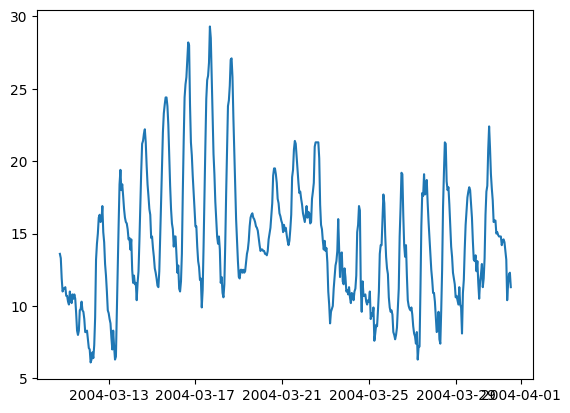

In [11]:
plt.plot(time_series)

Faça uma reamostragem da série temporal por dia (parâmetro `"D"`), agredada pela média (método `mean`). Plote essa reamostragem.

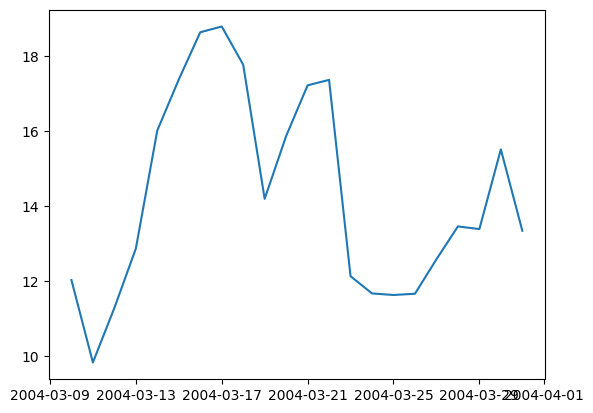

In [12]:
time_series_day = time_series.resample("D").mean()
plt.plot(time_series_day)

Faça uma nova reamostragem média por hora (parâmetro `hour`), mas agora utilizando o método `groupby` da série temporal. Plote o resultado.

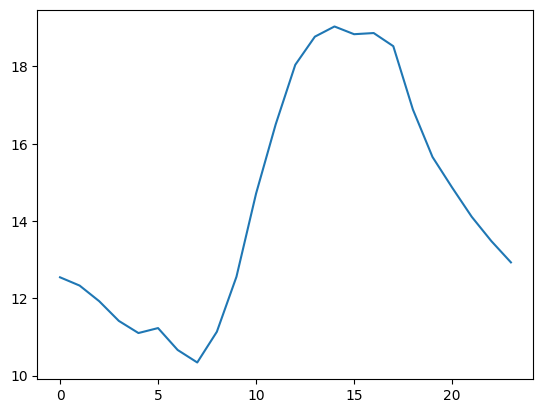

In [13]:
time_series_hour = time_series.groupby([lambda x: x.hour]).mean()
plt.plot(time_series_hour)

Utilize `season_decompose` para decompor a série temporal, recupere os atributos relacionados à tendência, sazonalidade e resíduos, e na sequência plote esses atributos.

In [14]:
decomposition = seasonal_decompose(time_series)
tendency = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

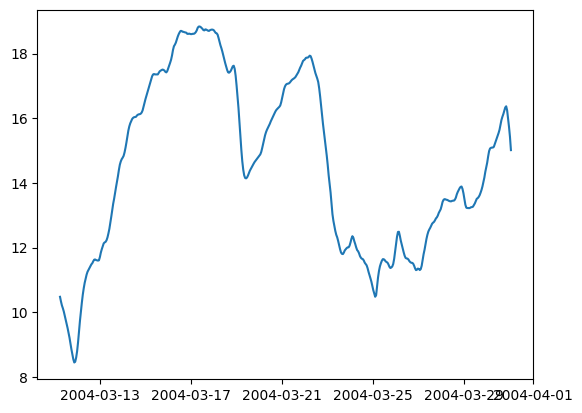

In [16]:
plt.plot(tendency)

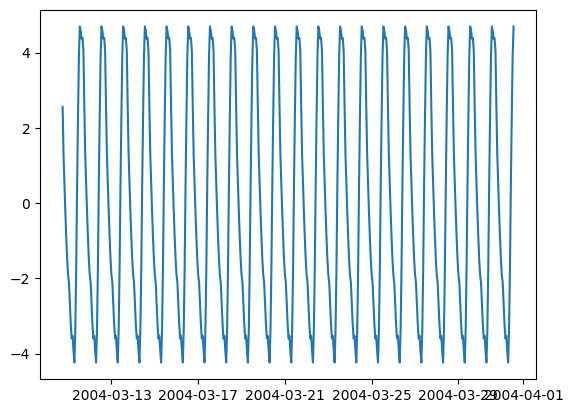

In [17]:
plt.plot(seasonality)

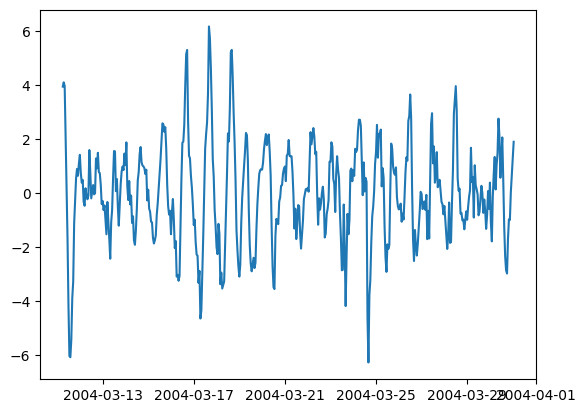

In [18]:
plt.plot(residual)

Ajuste um modelo do time Arima com os dados da série temporal.

In [19]:
model = auto_arima(time_series)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Exiba os valores de ordem no atributo `order`.

In [20]:
model.order

(2, 1, 1)

Faça predições para 24 períodos.

In [21]:
predictions = model.predict(n_periods=24)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Exiba as predições.

In [22]:
predictions

,0
2004-03-31 14:00:00,10.918623
2004-03-31 15:00:00,10.934580
2004-03-31 16:00:00,11.182957
2004-03-31 17:00:00,11.546412
2004-03-31 18:00:00,11.945846
2004-03-31 19:00:00,12.331571
2004-03-31 20:00:00,12.675545
2004-03-31 21:00:00,12.964912
2004-03-31 22:00:00,13.196877
2004-03-31 23:00:00,13.374807


Exiba o tamanho da série temporal.

In [23]:
len(time_series)

500

Separe os primeiros 490 períodos como dados de treino, e os restantes 10 como dados de teste.

In [24]:
train = time_series[:490]
test = time_series[490:]

Retreine o modelo, mas agora utilizando somente os dados de treino.

In [25]:
model = auto_arima(train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Gere predições para os 10 períodos seguintes.

In [26]:
predictions = model.predict(n_periods=10)
predictions

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0
2004-03-31 04:00:00,13.857680
2004-03-31 05:00:00,13.699078
2004-03-31 06:00:00,13.663927
2004-03-31 07:00:00,13.705430
2004-03-31 08:00:00,13.788946
2004-03-31 09:00:00,13.890130
2004-03-31 10:00:00,13.992918
2004-03-31 11:00:00,14.087599
2004-03-31 12:00:00,14.169100
2004-03-31 13:00:00,14.235561


Gere um gráfico exibindo os dados de treino, os dados de teste, e as predições feitas.

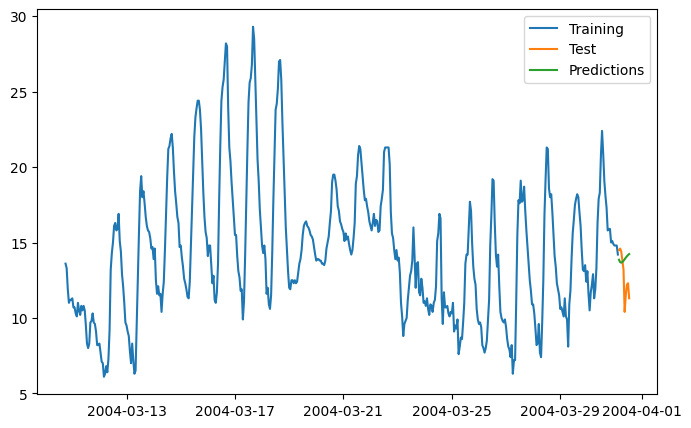

In [27]:
plt.figure(figsize=(8,5))
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(predictions, label = 'Predictions')
plt.legend();

Agora construa a base para apresentar ao Prophet.

Primeiro selecione as colunas `Datetime` e `T` de `base`, depois renomeie essas colunas para `ds` e `y`, e então exiba a nova base.

In [28]:
base_prophet = base[["Datetime", "T"]]
base_prophet.rename(columns={"Datetime": "ds", "T": "y"}, inplace=True)
base_prophet

/tmp/ipython-input-771719337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_prophet.rename(columns={"Datetime": "ds", "T": "y"}, inplace=True)


,ds,y
Datetime,,
2004-03-10 18:00:00,2004-03-10 18:00:00,13.6
2004-03-10 19:00:00,2004-03-10 19:00:00,13.3
2004-03-10 20:00:00,2004-03-10 20:00:00,11.9
2004-03-10 21:00:00,2004-03-10 21:00:00,11.0
2004-03-10 22:00:00,2004-03-10 22:00:00,11.2
...,...,...
2004-03-31 09:00:00,2004-03-31 09:00:00,10.4
2004-03-31 10:00:00,2004-03-31 10:00:00,11.5
2004-03-31 11:00:00,2004-03-31 11:00:00,12.2


Instancie e treine um modelo do tipo `Prophet`.

In [29]:
model = Prophet()
model.fit(base_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ofbzj43/krg_pepw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_ofbzj43/qfrven2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45947', 'data', 'file=/tmp/tmp_ofbzj43/krg_pepw.json', 'init=/tmp/tmp_ofbzj43/qfrven2o.json', 'output', 'file=/tmp/tmp_ofbzj43/prophet_modelzyutcg_c/prophet_model-20250828202635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prepare um dataframe para fazer predições futuras de 24 períodos, mas você também deve informar que a frequência é horária (parâmetro `freq="h"`). Faça e exiba as predições.

In [31]:
future = model.make_future_dataframe(periods=24, freq="h")
forecast = model.predict(future)
forecast.tail(24)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
500,2004-03-31 14:00:00,13.645949,15.582844,21.186271,13.645949,13.645949,4.717282,4.717282,4.717282,4.515093,4.515093,4.515093,0.202189,0.202189,0.202189,0.0,0.0,0.0,18.363231
501,2004-03-31 15:00:00,13.653452,15.525371,20.846896,13.653452,13.653452,4.672008,4.672008,4.672008,4.513000,4.513000,4.513000,0.159008,0.159008,0.159008,0.0,0.0,0.0,18.325460
502,2004-03-31 16:00:00,13.660956,15.407078,20.769061,13.660956,13.660956,4.397547,4.397547,4.397547,4.283670,4.283670,4.283670,0.113877,0.113877,0.113877,0.0,0.0,0.0,18.058503
503,2004-03-31 17:00:00,13.668460,14.589996,20.120136,13.668460,13.668460,3.766437,3.766437,3.766437,3.699605,3.699605,3.699605,0.066831,0.066831,0.066831,0.0,0.0,0.0,17.434896
504,2004-03-31 18:00:00,13.675963,13.629445,19.375401,13.675142,13.676656,2.725401,2.725401,2.725401,2.707485,2.707485,2.707485,0.017916,0.017916,0.017916,0.0,0.0,0.0,16.401364
505,2004-03-31 19:00:00,13.683467,12.542434,17.843195,13.680671,13.685897,1.454417,1.454417,1.454417,1.487229,1.487229,1.487229,-0.032812,-0.032812,-0.032812,0.0,0.0,0.0,15.137884
506,2004-03-31 20:00:00,13.690971,11.347572,16.662278,13.685840,13.696583,0.282000,0.282000,0.282000,0.367286,0.367286,0.367286,-0.085285,-0.085285,-0.085285,0.0,0.0,0.0,13.972971
507,2004-03-31 21:00:00,13.698475,10.224626,15.789029,13.689853,13.707777,-0.561083,-0.561083,-0.561083,-0.421655,-0.421655,-0.421655,-0.139428,-0.139428,-0.139428,0.0,0.0,0.0,13.137392
508,2004-03-31 22:00:00,13.705978,9.741426,15.163317,13.694050,13.719870,-1.103251,-1.103251,-1.103251,-0.908100,-0.908100,-0.908100,-0.195151,-0.195151,-0.195151,0.0,0.0,0.0,12.602727
509,2004-03-31 23:00:00,13.713482,9.480462,14.925553,13.698599,13.731085,-1.552766,-1.552766,-1.552766,-1.300406,-1.300406,-1.300406,-0.252360,-0.252360,-0.252360,0.0,0.0,0.0,12.160716


Plote as predições com o método `plot` da instância do modelo.

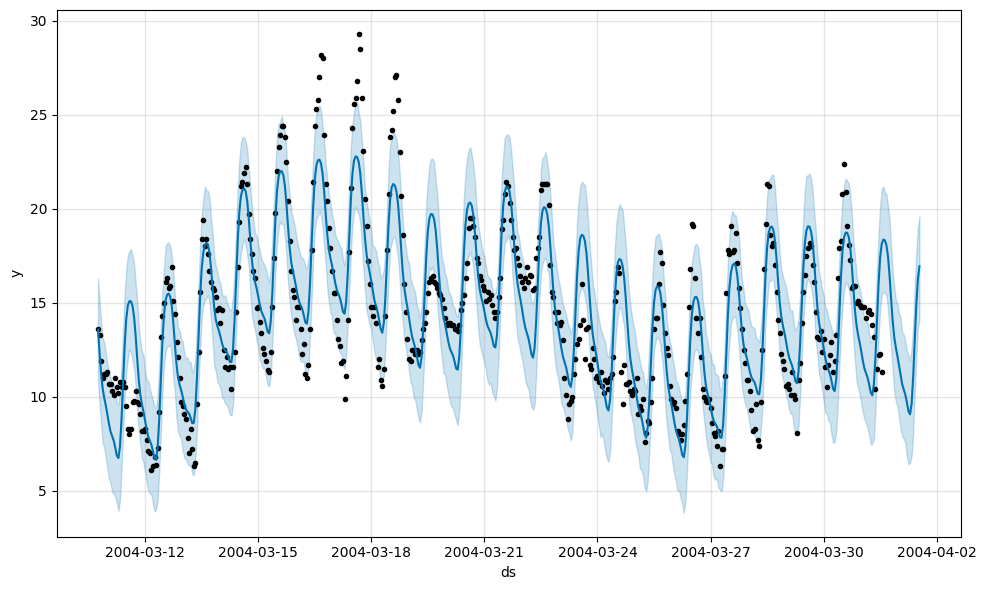

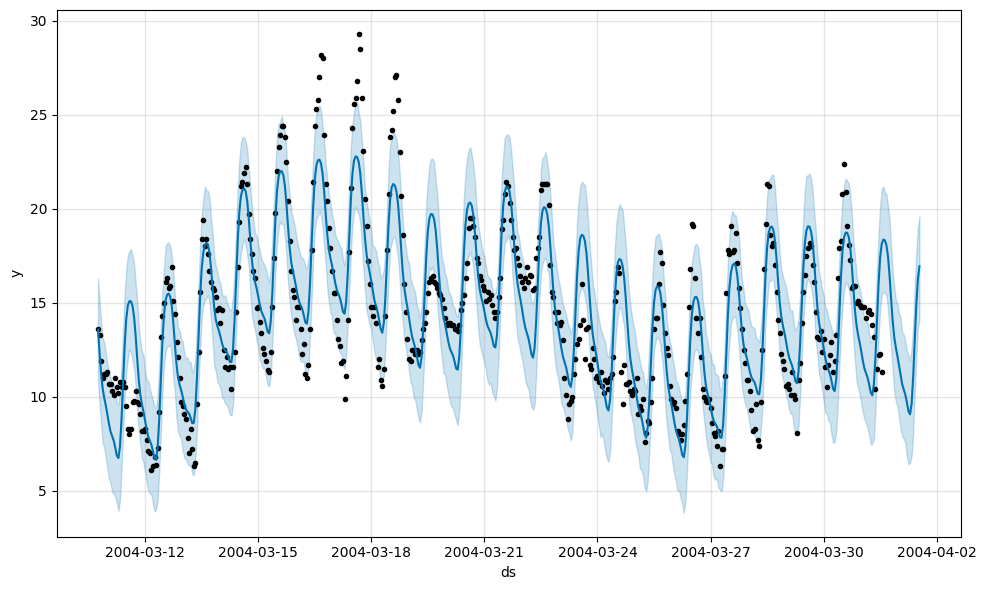

In [33]:
model.plot(forecast)

Também plote os componentes da predição.

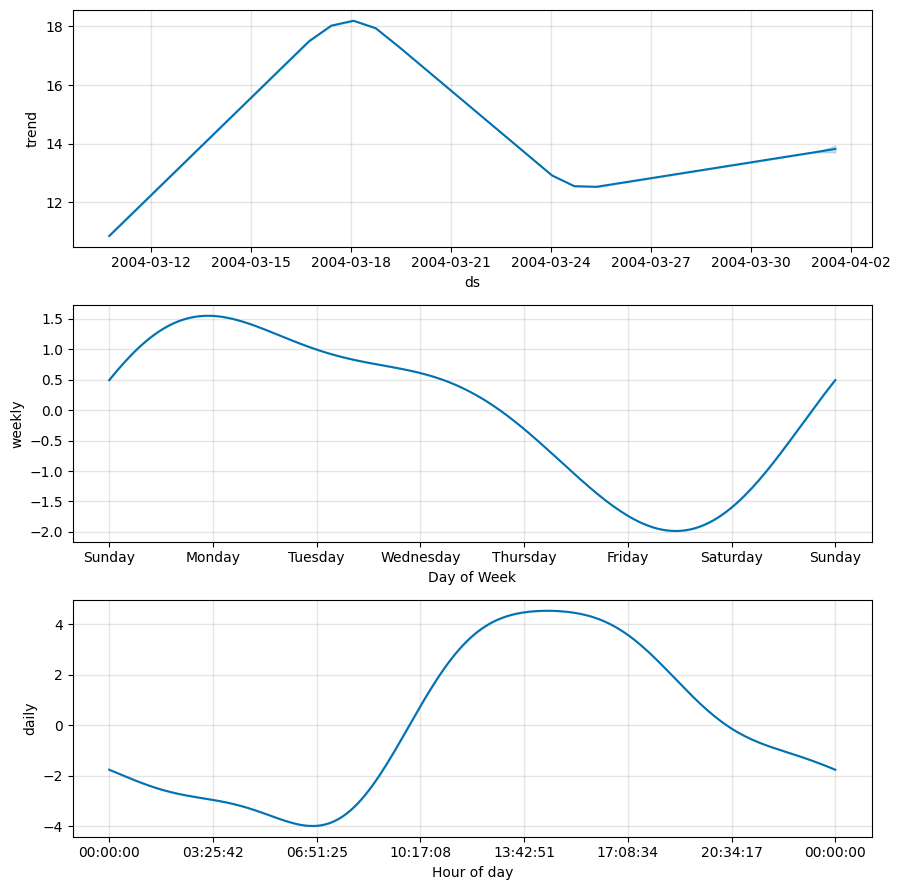

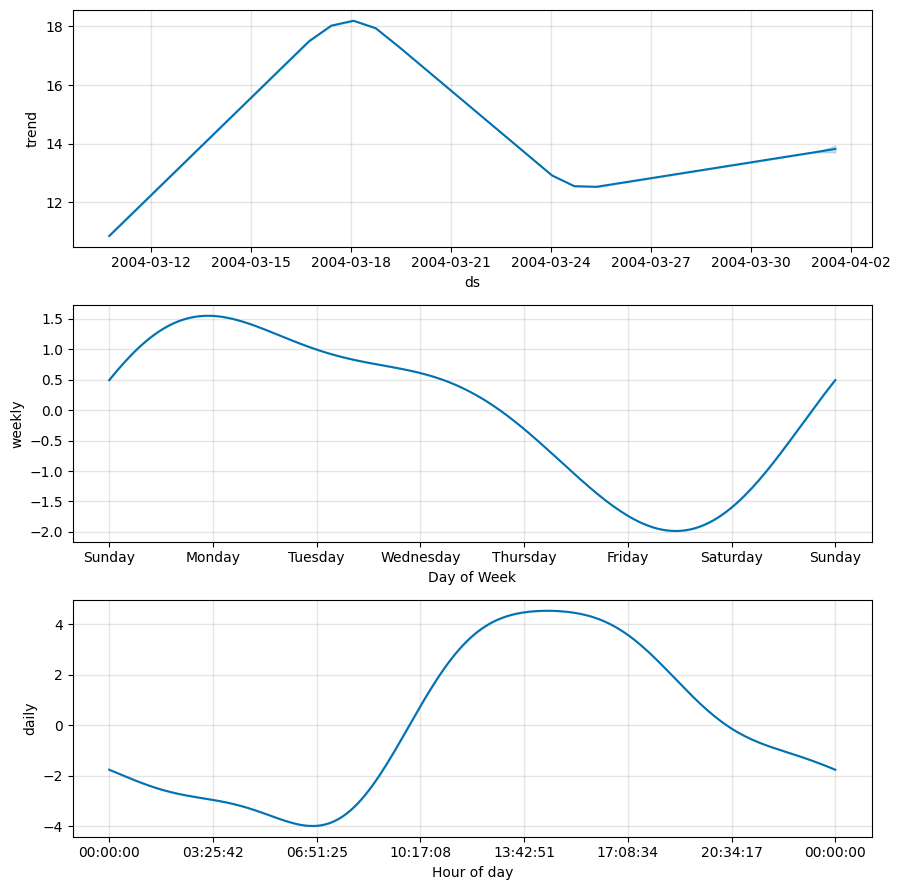

In [34]:
model.plot_components(forecast)

Agora plote as predições com a função `plot_plotly`.

In [36]:
plot_plotly(model, forecast)

E finalmente plote os componentes com a função `plot_components_plotly`.

In [37]:
plot_components_plotly(model, forecast)